# Electricity Demand Forecasting Project | Part 2 - Recurrent Neural Networks

**Import libraries and packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime as dt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import tensorflow as tf

2025-06-17 22:30:32.226580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Relevant helper functions created in _Part 1_ are summarised in a separate notebook and imported below.**

In [2]:
%run Functions.ipynb

## 1. Import, Clean and Explore Data

In [3]:
# Import Electricity Demand Data
data_dict = {}

for data_year in range(2016, 2025):
    data_dict[data_year] = pd.read_csv(f'data/total_load_{data_year}.csv')

data_full = pd.concat(data_dict.values())

data_2025 = pd.read_csv('data/total_load_2025.csv')

In [4]:
data_full = format_data(data_full)

data_2025 = format_data(data_2025)
data_2025.drop(data_2025.loc['2025-05-01':].index, inplace=True)
data_2025['Load'] = data_2025['Load'].astype(float)

In [5]:
# Check length of dataset - result should be 0
len(data_full) - (dt.date(2025, 1, 1) - dt.date(2016, 1, 1)).days * 96

0

In [6]:
data_train = data_full.loc[:'2023-12-31'].copy()
data_valid = data_full.loc['2024-01-01':].copy()

In [7]:
std_load = StandardScaler()

data_train_transformed = pd.DataFrame(std_load.fit_transform(data_train),
                                      columns=data_train.columns,
                                      index=data_train.index)

data_valid_transformed = pd.DataFrame(std_load.transform(data_valid),
                                           columns=data_valid.columns,
                                           index=data_valid.index)

y_train_true = data_train.loc['2016-01-22':, 'Load'].copy()
y_valid_true = data_valid.loc['2024-01-22':, 'Load'].copy()

In [8]:
public_holidays = list(holidays.country_holidays(country='Netherlands', years=range(2015, 2026)).keys())

## 2. Feature Selection

We will use the same features determined in the Part 1:
- Lagging load values corresponding to the same time interval of the prior 3 weeks (21 values).
- Holiday indicator (1 value).

We will create sequential datasets using the `timeseries_dataset_from_array()` functionality. For our holiday indicator, we will need to shift this one day ahead - i.e. "holiday tomorrow", corresponding to the target. Therefore in our data processing step we will append one more day after the end of each period, to capture this in the shift, and then drop that day.

This is included in section 3 below.

## 3. Model Selection and Evaluation

We will prepare the model data, train and evaluate the following RNN models:
- Simple RNN
- Deep RNN
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In [9]:
# Helper function to simplify train_test_model function below
def invert_pred(y_true, y_pred, transformer=std_load):
    return pd.Series(transformer.inverse_transform(y_pred.reshape(-1, 1))[:, 0],
                     index=y_true.index)

def mae(y_true, y_pred, invert=True):
    if invert:
        return mean_absolute_error(y_true, invert_pred(y_true, y_pred))
    else:
        return mean_absolute_error(y_true, y_pred)

In [10]:
# Helper function to train and evaluate each model
def train_test_model(model, train_ds, valid_ds, learning_rate, y_train=y_train_true, y_valid=y_valid_true,
                     epochs=50, train_ds_pred=None):
    """
    Trains and evaluates a model (MAE), returning predictions if specified.
    """
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=5, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, metrics=["mae"])
    
    history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs,
                        callbacks=[early_stopping_cb])

    y_valid_pred = model.predict(valid_ds)
    
    if train_ds_pred is not None:
        y_train_pred = model.predict(train_ds_pred)
        return mae(y_train, y_train_pred), mae(y_valid, y_valid_pred)
    else: return mae(y_valid, y_valid_pred)

In [11]:
# Prep model data
X_train = add_weekday_holiday(pd.concat([data_train_transformed, data_valid.loc['2024-01-01']]),
                              public_holidays)
X_valid = add_weekday_holiday(pd.concat([data_valid_transformed, data_2025.loc['2025-01-01']]),
                              public_holidays)

X_train['Holiday_next_day'] = X_train['Holiday'].shift(-96) # 1 day = 96 time intervals
X_train.drop('Holiday', axis=1, inplace=True)

X_valid['Holiday_next_day'] = X_valid['Holiday'].shift(-96) # 1 day = 96 time intervals
X_valid.drop('Holiday', axis=1, inplace=True)

X_train.drop(X_train.loc['2024-01-01'].index, inplace=True)
X_valid.drop(X_valid.loc['2025-01-01'].index, inplace=True)

In [12]:
# Prep model datasets
seq_length = 21 # 3 weeks

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train.to_numpy(),
    targets=X_train['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96, # daily values
    batch_size=32,
    shuffle=True,
    seed=42)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_valid.to_numpy(),
    targets=X_valid['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32,
    seed=42)

train_ds_pred = tf.keras.utils.timeseries_dataset_from_array(
    X_train.to_numpy(),
    targets=X_train['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32,
    shuffle=False)

In [13]:
tf.random.set_seed(42)
simple_rnn = tf.keras.Sequential()
simple_rnn.add(tf.keras.layers.Input(shape=[None, 2]))
simple_rnn.add(tf.keras.layers.SimpleRNN(32))
simple_rnn.add(tf.keras.layers.Dense(1))

simple_rnn_mae_train, simple_rnn_mae_valid = train_test_model(simple_rnn, train_ds, valid_ds, learning_rate=0.02,
                                               train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {simple_rnn_mae_train:.2f}')
print(f'Validation MAE: {simple_rnn_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 0.0404 - mae: 0.1909 - val_loss: 0.0240 - val_mae: 0.1564
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 0.0324 - mae: 0.1714 - val_loss: 0.0227 - val_mae: 0.1532
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 0.0309 - mae: 0.1675 - val_loss: 0.0232 - val_mae: 0.1551
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 170s 20ms/step - loss: 0.0298 - mae: 0.1649 - val_loss: 0.0248 - val_mae: 0.1640
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 0.0288 - mae: 0.1630 - val_loss: 0.0240 - val_mae: 0.1594
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 0.0282 - mae: 0.1619 - val_loss: 0.0242 - val_mae: 0.1590
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 0.0276 - mae: 0.1608 - val_loss: 0.0239 - val_mae: 0.1576
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step

Training MAE: 341.21
Validation MAE: 323.63


In [14]:
# Deep RNN
tf.random.set_seed(42)
deep_rnn = tf.keras.Sequential()
deep_rnn.add(tf.keras.layers.Input(shape=[None, 2]))
deep_rnn.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))
deep_rnn.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))
deep_rnn.add(tf.keras.layers.SimpleRNN(32))
deep_rnn.add(tf.keras.layers.Dense(1))

deep_rnn_mae_train, deep_rnn_mae_valid = train_test_model(deep_rnn, train_ds, valid_ds, learning_rate=0.02,
                                                         train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {deep_rnn_mae_train:.2f}')
print(f'Validation MAE: {deep_rnn_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 100s 11ms/step - loss: 0.0466 - mae: 0.2070 - val_loss: 0.0258 - val_mae: 0.1671
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 100s 11ms/step - loss: 0.0301 - mae: 0.1688 - val_loss: 0.0246 - val_mae: 0.1596
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 99s 11ms/step - loss: 0.0270 - mae: 0.1614 - val_loss: 0.0256 - val_mae: 0.1605
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - loss: 0.0246 - mae: 0.1553 - val_loss: 0.0264 - val_mae: 0.1635
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - loss: 0.0228 - mae: 0.1504 - val_loss: 0.0272 - val_mae: 0.1675
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - loss: 0.0211 - mae: 0.1455 - val_loss: 0.0269 - val_mae: 0.1639
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 141s 12ms/step - loss: 0.0201 - mae: 0.1427 - val_loss: 0.0269 - val_mae: 0.1648
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step

Training MAE: 332.13
Validation MAE: 337.05


In [15]:
# LSTM Model
tf.random.set_seed(42)
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Input(shape=[None, 2]))
lstm.add(tf.keras.layers.LSTM(32))
lstm.add(tf.keras.layers.Dense(1))

lstm_mae_train, lstm_mae_valid = train_test_model(lstm, train_ds, valid_ds, learning_rate=0.02,
                                                             train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {lstm_mae_train:.2f}')
print(f'Validation MAE: {lstm_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - loss: 0.1117 - mae: 0.3506 - val_loss: 0.0397 - val_mae: 0.2029
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0495 - mae: 0.2153 - val_loss: 0.0336 - val_mae: 0.1904
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - loss: 0.0429 - mae: 0.1961 - val_loss: 0.0294 - val_mae: 0.1734
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 0.0396 - mae: 0.1870 - val_loss: 0.0293 - val_mae: 0.1778
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 0.0380 - mae: 0.1832 - val_loss: 0.0267 - val_mae: 0.1660
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 73s 8ms/step - loss: 0.0360 - mae: 0.1778 - val_loss: 0.0258 - val_mae: 0.1629
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 73s 8ms/step - loss: 0.0348 - mae: 0.1752 - val_loss: 0.0266 - val_mae: 0.1661
Epoch 8/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0337 - mae: 0.1723 - val_loss: 0.0261 - val_mae: 0.1635
Epoch 9/50
8703/8703 ━━━━━━━━━━━

In [16]:
# GRU Model
tf.random.set_seed(42)
gru = tf.keras.Sequential()
gru.add(tf.keras.layers.Input(shape=[None, 2]))
gru.add(tf.keras.layers.GRU(32))
gru.add(tf.keras.layers.Dense(1))

gru_mae_train, gru_mae_valid = train_test_model(gru, train_ds, valid_ds, learning_rate=0.02,
                                                             train_ds_pred=train_ds_pred)

print(f'\nTraining MAE: {gru_mae_train:.2f}')
print(f'Validation MAE: {gru_mae_valid:.2f}')

Epoch 1/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.0925 - mae: 0.3095 - val_loss: 0.0280 - val_mae: 0.1707
Epoch 2/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - loss: 0.0370 - mae: 0.1822 - val_loss: 0.0241 - val_mae: 0.1573
Epoch 3/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0335 - mae: 0.1725 - val_loss: 0.0249 - val_mae: 0.1627
Epoch 4/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0323 - mae: 0.1686 - val_loss: 0.0240 - val_mae: 0.1571
Epoch 5/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0316 - mae: 0.1663 - val_loss: 0.0238 - val_mae: 0.1563
Epoch 6/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0311 - mae: 0.1647 - val_loss: 0.0238 - val_mae: 0.1566
Epoch 7/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0308 - mae: 0.1634 - val_loss: 0.0230 - val_mae: 0.1536
Epoch 8/50
8703/8703 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.0304 - mae: 0.1623 - val_loss: 0.0236 - val_mae: 0.1571
Epoch 9/50
8703/8703 ━━━━━━━━━━━

All of the models perform well, achieving Validation MAE similar to the `Linear Regression` model from Part 1. While most of the performance is already captured in the `SimpleRNN` model, the `GRU` model achieved the best performance (considering both training MAE and validation MAE). We will investigate the training residuals to explore whether we can improve the performance further through a hybrid model.

1035/1035 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
MAE: 367.21


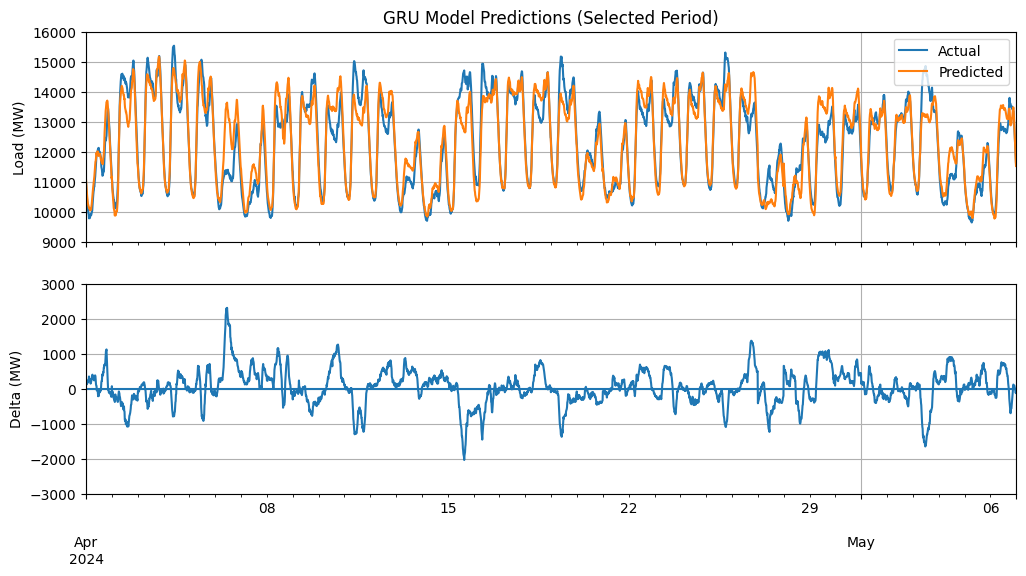

In [38]:
# Plot results (selected month, starting on a Monday)
gru_valid_pred = invert_pred(y_valid_true, gru.predict(valid_ds))

plot_results(y_valid_true.loc['2024-04-01':'2024-05-06'],
             gru_valid_pred.loc['2024-04-01':'2024-05-06'],
             title='GRU Model Predictions (Selected Period)')

In [39]:
gru_train_pred = invert_pred(y_train_true, gru.predict(train_ds_pred))
gru_resid = pd.DataFrame(y_train_true - gru_train_pred, columns=['Residual'])

8703/8703 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step


In [40]:
resid_time = lstm_resid.copy()
resid_time['Time'] = resid_time.index.time
resid_time_by_day = resid_time.groupby('Time')['Residual'].mean()

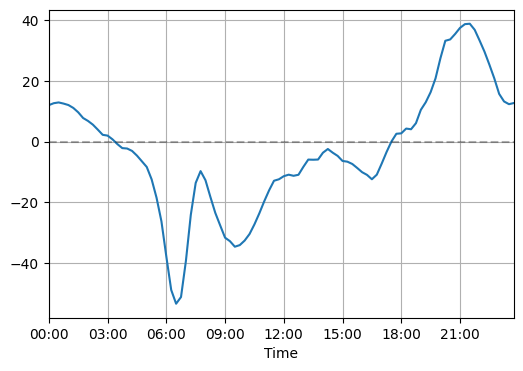

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
resid_time_by_day.plot(ax=ax)
ax.set_xlim('00:00:00','23:45:00')
ax.set_xticks(resid_time_by_day.index[::12])
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.grid();

Unlike the `LinearRegression` model, the residuals do not follow the daily electricity demand pattern. The pattern observed appears to be the result of the particular training run of the model. We will therefore not follow the hybrid approach of Part 1, as this is not expected to yield further performance on the residuals.

## 4. Final Results

In [51]:
data_test = pd.concat([
    data_valid.loc['2024-12-11':],
    data_2025.loc['2025-01-01':],
])

data_test_transformed = pd.DataFrame(std_load.transform(data_test),
                                          columns=data_test.columns,
                                          index=data_test.index)

y_test_true = data_2025['Load']

In [52]:
# Prep test data
X_test = add_weekday_holiday(data_test_transformed, public_holidays)
X_test['Holiday_next_day'] = X_test['Holiday'].shift(-96) # 1 day = 96 time intervals
X_test.drop('Holiday', axis=1, inplace=True)

In [53]:
# Prep test dataset
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_test.to_numpy(),
    targets=X_test['Load'][seq_length*96:],
    sequence_length=seq_length,
    sampling_rate=96,
    batch_size=32)

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
MAE: 440.81


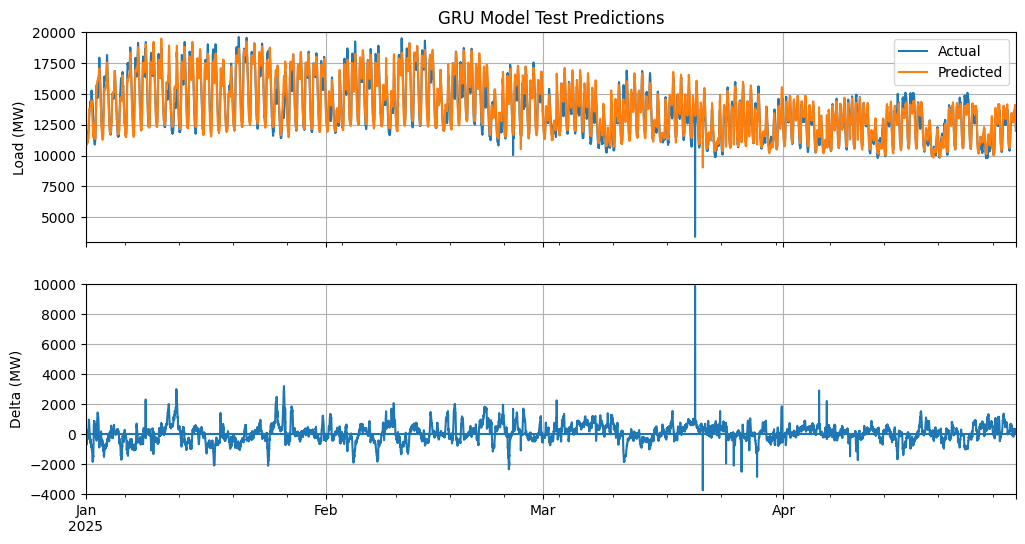

In [54]:
gru_test_pred = invert_pred(y_test_true, gru.predict(test_ds))
gru_mae_test = mae(y_test_true, gru_test_pred, invert=False)

plot_results(y_test_true,
             lstm_test_pred,
             title='GRU Model Test Predictions')

MAE: 302.94


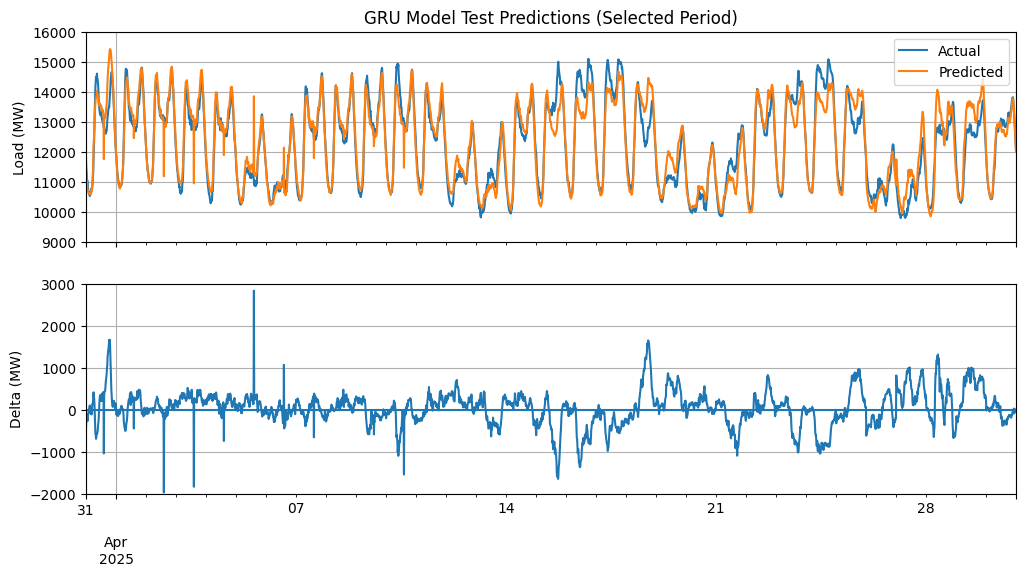

In [58]:
plot_results(y_test_true.loc['2025-03-31':],
             gru_test_pred.loc['2025-03-31':],
             title='GRU Model Test Predictions (Selected Period)')

plt.savefig('gru-predictions.png', dpi=200, bbox_inches='tight');

In [59]:
simple_rnn_mae_test = mae(y_test_true, simple_rnn.predict(test_ds))
deep_rnn_mae_test = mae(y_test_true, deep_rnn.predict(test_ds))
gru_mae_test = mae(y_test_true, gru.predict(test_ds))

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [60]:
summary_df = pd.DataFrame({
    'Training MAE': [simple_rnn_mae_train, deep_rnn_mae_train, lstm_mae_train, gru_mae_train],
    'Validation MAE': [simple_rnn_mae_valid, deep_rnn_mae_valid, lstm_mae_valid, gru_mae_valid],
    'Test MAE': [simple_rnn_mae_test, deep_rnn_mae_test, lstm_mae_test, gru_mae_test]
}, index=['Simple RNN', 'Deep RNN', 'LSTM', 'GRU'])

for model in summary_df.index:
    summary_df.loc[f'{model} (%)'] = (summary_df.loc[model] / 
                                     (y_train_true.mean(), y_valid_true.mean(), y_test_true.mean()) * 100)

summary_df = summary_df.round(2)
summary_df

,Training MAE,Validation MAE,Test MAE
Simple RNN,341.21,323.63,408.22
Deep RNN,332.13,337.05,419.04
LSTM,341.45,333.58,440.81
GRU,329.24,321.05,393.34
Simple RNN (%),2.72,2.49,2.96
Deep RNN (%),2.65,2.59,3.04
LSTM (%),2.72,2.57,3.20
GRU (%),2.62,2.47,2.86


Each of the RNN models performed well, with the GRU model achieving the best performance.